Training model...

Step 1: Analyzing feature correlations...

Highly correlated feature pairs:
                     Feature1                     Feature2  Correlation
0                   GrLivArea                 TotRmsAbvGrd     0.825489
1                   GrLivArea    GrLivArea_TotalBsmtSF_int     0.736369
2                   GrLivArea       GrLivArea_1stFlrSF_int     0.832277
3                   GrLivArea       GrLivArea_2ndFlrSF_int     0.794282
4                   GrLivArea     TotalBsmtSF_2ndFlrSF_int     0.783544
..                        ...                          ...          ...
68  ExterQual_OverallQual_int     BsmtQual_OverallQual_int     0.768425
69  ExterQual_OverallQual_int  KitchenQual_OverallQual_int     0.829213
70   BsmtQual_KitchenQual_int     BsmtQual_OverallQual_int     0.865021
71   BsmtQual_KitchenQual_int  KitchenQual_OverallQual_int     0.880473
72   BsmtQual_OverallQual_int  KitchenQual_OverallQual_int     0.725006

[73 rows x 3 columns]

Step 2: Calculati

C:\Users\tejes\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                        Feature           VIF
0                     GrLivArea           inf
2                      1stFlrSF           inf
3                      2ndFlrSF           inf
4                  LowQualFinSF           inf
34    GrLivArea_TotalBsmtSF_int  3.819742e+04
38     TotalBsmtSF_1stFlrSF_int  2.618189e+04
37        GrLivArea_LotArea_int  1.585493e+04
42         1stFlrSF_LotArea_int  1.091711e+04
39     TotalBsmtSF_2ndFlrSF_int  3.144618e+03
43         2ndFlrSF_LotArea_int  1.291418e+03
35       GrLivArea_1stFlrSF_int  6.158749e+02
18                 TotRmsAbvGrd  5.839365e+02
50                  AvgRoomSize  4.416844e+02
26                  OverallQual  3.373313e+02
48     BsmtQual_OverallQual_int  2.711916e+02
49  KitchenQual_OverallQual_int  2.513609e+02
46    ExterQual_OverallQual_int  2.337741e+02
1                   TotalBsmtSF  2.090812e+02
32                     BsmtQual  1.684395e+02
40      TotalBsmtSF_LotArea_int  1.613178e+02
33                  KitchenQual  1

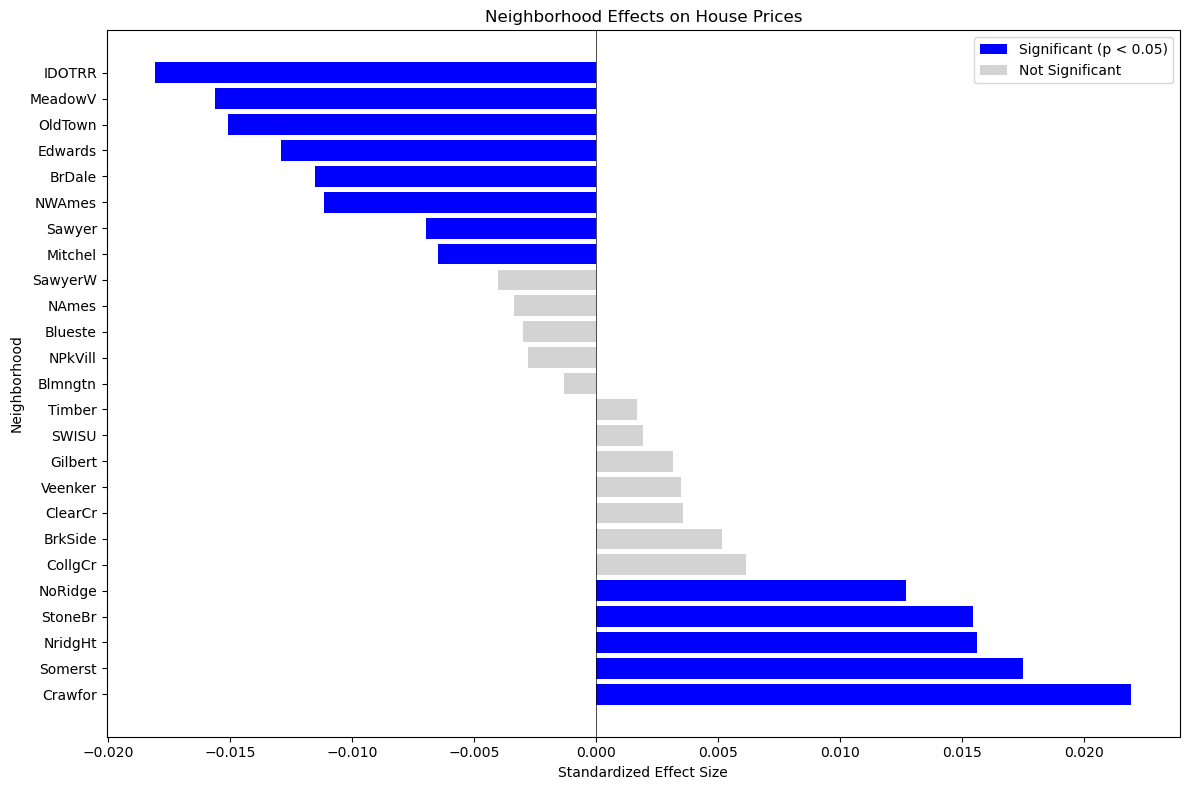


Making predictions...

Submission file created: submission_V1.csv

First few predictions:
     Id      SalePrice
0  1461  125325.890867
1  1462  151329.836795
2  1463  183411.249302
3  1464  197217.931197
4  1465  206642.468922

Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     209.3
Date:                Fri, 08 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:53:50   Log-Likelihood:                 1103.2
No. Observations:                1460   AIC:                            -2054.
Df Residuals:                    1384   BIC:                            -1653.
Df Model:                          75                                         
Covariance Type:            nonrobust 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def prepare_features(df, training=True, columns=None):
    """
    Prepare and preprocess features for model training/testing.

    This function handles:
    - Age-related features calculation (e.g., years since remodel).
    - One-hot encoding for categorical features (Neighborhood).
    - Filling NaNs and handling missing data.
    - Encoding quality features (e.g., ExterQual).
    - Creation of interaction terms to capture feature relationships.

    Parameters:
    - df (DataFrame): Input data for feature preparation.
    - training (bool): Flag to differentiate between training and test data.
    - columns (list): Required columns for test data preparation.

    Returns:
    - DataFrame of prepared features and a list of columns (if training).
    """
    
    # Copy DataFrame to avoid modifying the original data
    df = df.copy()
    
    # Age-based features
    df['Age_at_Sale'] = df['YrSold'] - df['YearBuilt']
    df['Years_Since_Remod'] = df['YrSold'] - df['YearRemodAdd']
    
    # One-hot encode the 'Neighborhood' categorical feature
    neighborhood_dummies = pd.get_dummies(df['Neighborhood'], prefix='Neighborhood')
    
    # Specify numeric features we want to include in the model
    numeric_features = [
        'GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'BsmtFinSF1', 'BsmtFinSF2', 'LotArea', 'LotFrontage', 'MasVnrArea',
        'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
        '3SsnPorch', 'ScreenPorch', 'PoolArea', 'TotRmsAbvGrd', 'BedroomAbvGr',
        'KitchenAbvGr', 'Fireplaces', 'FullBath', 'HalfBath', 'BsmtFullBath',
        'BsmtHalfBath', 'OverallQual', 'OverallCond', 'Age_at_Sale', 
        'Years_Since_Remod', 'MiscVal'
    ]
    
    # Check for missing numeric features in the input DataFrame
    available_numeric = [col for col in numeric_features if col in df.columns]
    if len(available_numeric) != len(numeric_features):
        missing = set(numeric_features) - set(available_numeric)
        print(f"Warning: Missing numeric features: {missing}")
        numeric_features = available_numeric
    
    # Fill NaN values in numeric features with 0
    for feature in numeric_features:
        if feature in df.columns:
            df[feature] = df[feature].fillna(0)
    
    # Encoding quality features using a mapping for categorical levels
    categorical_features = ['ExterQual', 'BsmtQual', 'KitchenQual']
    quality_map = {'Ex': 3, 'Gd': 2, 'Ta': 1, 'Fa': 0, 'Po': 0}
    encoded_features = []
    
    for feature in categorical_features:
        if feature in df.columns:
            df[feature] = df[feature].fillna('NA')
            df[feature] = df[feature].map(lambda x: quality_map.get(x, 0))
            encoded_features.append(feature)
        else:
            print(f"Warning: Missing categorical feature: {feature}")
    
    # Combine all processed features into one DataFrame
    X = pd.concat([df[numeric_features], df[encoded_features], neighborhood_dummies], axis=1)
    
    # Create interaction terms to capture nonlinear relationships
    X = create_interaction_terms(X)
    
    # Return features and list of columns if in training mode
    if training:
        return X, X.columns.tolist()
    else:
        # Handle missing columns for test set by adding columns with zeros
        missing_cols = set(columns) - set(X.columns)
        for col in missing_cols:
            X[col] = 0
        return X[columns]

def create_interaction_terms(X):
    """
    Generate interaction terms between related features to improve model complexity.

    Parameters:
    - X (DataFrame): Input feature data.

    Returns:
    - DataFrame with interaction terms added.
    """
    X = X.copy()
    numeric_X = X.select_dtypes(include=[np.number])
    
    # Create interactions among area features
    area_features = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LotArea']
    for i in range(len(area_features)):
        for j in range(i+1, len(area_features)):
            name = f"{area_features[i]}_{area_features[j]}_int"
            X[name] = X[area_features[i]] * X[area_features[j]]
    
    # Quality interactions
    quality_features = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual']
    for i in range(len(quality_features)):
        for j in range(i+1, len(quality_features)):
            name = f"{quality_features[i]}_{quality_features[j]}_int"
            X[name] = X[quality_features[i]] * X[quality_features[j]]
    
    # Average room size calculation (to capture room size variation)
    if all(f in X.columns for f in ['TotRmsAbvGrd', 'GrLivArea']):
        X['AvgRoomSize'] = X['GrLivArea'] / X['TotRmsAbvGrd'].replace(0, 1)
    
    # Interaction between age and quality
    if all(f in X.columns for f in ['Age_at_Sale', 'OverallQual']):
        X['Age_Quality_int'] = X['Age_at_Sale'] * X['OverallQual']
    
    return X

def analyze_correlations(X, threshold=0.7):
    """
    Compute and identify highly correlated feature pairs.

    Parameters:
    - X (DataFrame): Feature data.
    - threshold (float): Correlation threshold.

    Returns:
    - Correlation matrix and DataFrame of high correlation pairs.
    """
    numeric_X = X.select_dtypes(include=[np.number])
    corr_matrix = numeric_X.corr()
    high_corr_pairs = []
    
    # Check correlations above threshold
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'Feature1': corr_matrix.columns[i],
                    'Feature2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    
    return corr_matrix, pd.DataFrame(high_corr_pairs)

def calculate_vif(X):
    """
    Calculate the Variance Inflation Factor (VIF) to detect multicollinearity.

    Parameters:
    - X (DataFrame): Numeric feature data.

    Returns:
    - DataFrame of features with VIF values.
    """
    numeric_X = X.select_dtypes(include=[np.number])
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_X.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_X.values, i) 
                       for i in range(numeric_X.shape[1])]
    
    return vif_data.sort_values('VIF', ascending=False)

def analyze_neighborhood_effects(model, feature_columns):
    """
    Assess neighborhood effect on prices based on model coefficients.

    Parameters:
    - model: Trained regression model.
    - feature_columns (list): List of features used in the model.

    Returns:
    - DataFrame of neighborhood effects with significance.
    """
    neighborhood_features = [col for col in model.params.index 
                             if str(col).startswith('Neighborhood_')]
    
    if not neighborhood_features:
        print("\nNo neighborhood effects found in model")
        return pd.DataFrame()
    
    # Summary of neighborhood effects
    neighborhood_effects = pd.DataFrame({
        'Neighborhood': [col.replace('Neighborhood_', '') for col in neighborhood_features],
        'Coefficient': model.params[neighborhood_features],
        'P_Value': model.pvalues[neighborhood_features],
        'Std_Error': model.bse[neighborhood_features]
    })
    
    neighborhood_effects['Significant'] = neighborhood_effects['P_Value'] < 0.05
    neighborhood_effects = neighborhood_effects.sort_values('Coefficient', ascending=False)
    
    print("\nNeighborhood Effects Summary:")
    print("-" * 50)
    print(f"Number of neighborhoods: {len(neighborhood_effects)}")
    print(f"Significant neighborhoods: {neighborhood_effects['Significant'].sum()}")
    print("\nTop 5 positive effects:")
    print(neighborhood_effects.head())
    print("\nBottom 5 effects:")
    print(neighborhood_effects.tail())
    
    return neighborhood_effects

def plot_neighborhood_effects(neighborhood_effects):
    """
    Plot the neighborhood effects on house prices.
    """
    if neighborhood_effects.empty:
        return
        
    plt.figure(figsize=(12, 8))
    
    colors = ['blue' if sig else 'lightgrey' 
              for sig in neighborhood_effects['Significant']]
    
    plt.barh(neighborhood_effects['Neighborhood'],
             neighborhood_effects['Coefficient'],
             color=colors)
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.title('Neighborhood Effects on House Prices')
    plt.xlabel('Standardized Effect Size')
    plt.ylabel('Neighborhood')
    
    legend_elements = [
        Patch(facecolor='blue', label='Significant (p < 0.05)'),
        Patch(facecolor='lightgrey', label='Not Significant')
    ]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

def predict_prices(model, test_df, scaler, feature_columns):
    """
    Make predictions on test data using a trained model.

    Parameters:
    - model: Trained regression model.
    - test_df (DataFrame): Test data for predictions.
    - scaler: Scaler used to transform training data.
    - feature_columns (list): Features used in training.

    Returns:
    - Array of predicted sale prices.
    """
    X_test = prepare_features(test_df, training=False, columns=feature_columns)
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = sm.add_constant(X_test_scaled)
    log_predictions = model.predict(X_test_scaled)
    predictions = np.exp(log_predictions)
    return predictions

def create_submission(test_df, predictions, output_file='submission_V1.csv'):
    """
    Generate and save a CSV file for Kaggle submission.

    Parameters:
    - test_df (DataFrame): Test DataFrame containing property IDs.
    - predictions (array): Predicted house prices.
    - output_file (str): Filename for output CSV.

    Returns:
    - CSV file saved to disk.
    """
    submission = pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': predictions
    })
    submission.to_csv(output_file, index=False)
    print(f"\nSubmission file created: {output_file}")
    print("\nFirst few predictions:")
    print(submission.head())

if __name__ == "__main__":
    try:
        # Load training and test data
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        
        # Prepare training features and target variable (log of SalePrice)
        print("Training model...")
        X, feature_columns = prepare_features(train_df, training=True)
        y = np.log(train_df['SalePrice'])
        
        # Step 1: Feature correlation analysis
        print("\nStep 1: Analyzing feature correlations...")
        corr_matrix, high_corr = analyze_correlations(X, threshold=0.7)
        if len(high_corr) > 0:
            print("\nHighly correlated feature pairs:")
            print(high_corr)
        
        # Step 2: Variance Inflation Factor calculation
        print("\nStep 2: Calculating VIF scores...")
        vif_df = calculate_vif(X)
        print(vif_df)
        
        # Standardize the features and fit the model
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        
        # Fit an Ordinary Least Squares regression model
        X_scaled_const = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_scaled_const).fit()
        
        # Model performance metrics
        metrics = {
            'R_squared': model.rsquared,
            'Adj_R_squared': model.rsquared_adj,
            'AIC': model.aic,
            'BIC': model.bic,
            'RMSE': np.sqrt(np.mean((y - model.predict(X_scaled_const))**2)),
            'Num_Features': len(feature_columns)
        }
        
        print("\nModel performance metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Analyze neighborhood effects and plot results
        neighborhood_effects = analyze_neighborhood_effects(model, feature_columns)
        plot_neighborhood_effects(neighborhood_effects)
        
        # Make predictions on the test set
        print("\nMaking predictions...")
        predictions = predict_prices(model, test_df, scaler, feature_columns)
        
        # Create a submission file
        create_submission(test_df, predictions)
        
        # Print final model summary
        print("\nFinal Model Summary:")
        print(model.summary())
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise
